### Convolutional Neural Network
**Convolutional Neural Network (CNN)** is a type of `deep` learning model designed to process data with a grid-like structure, such as images, by using layers that automatically and adaptively learn spatial hierarchies of features. It consists of convolutional layers that apply filters to extract features, pooling layers that reduce spatial dimensions, and fully connected layers for classification. CNNs are widely used in image recognition, object detection, and computer vision tasks due to their efficiency and accuracy.


Our task is to build a CNN model capable of correctly classifying whether an image is of the four labels:
- `tom`- only contains tom
- `jerry`-only contains jerry
- `tom_jerry_1` contains both tom and jerry
- `tom_jerry_0` contains none of them

In [21]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

##keras models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
# Define base directory
base_dir = 'tj'

# Check subfolders (should be: tom, jerry, tom_jerry_1, tom_jerry_0)
print("Subfolders in the dataset directory:")
print(os.listdir(base_dir))

Subfolders in the dataset directory:
['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']


In [23]:
#loading ground_truth CSV
ground_truth_df = pd.read_csv('./csv_data/ground_truth.csv')
print("\nGround truth sample:")
ground_truth_df.tail()



Ground truth sample:


,filename,tom,jerry
5473,frame5473.jpg,0,0
5474,frame5474.jpg,0,0
5475,frame5475.jpg,0,0
5476,frame5476.jpg,0,0
5477,frame5477.jpg,0,0


Before feeding images into a neural network, we need to know:

- What size they are (height × width × channels)

- Whether they're consistent in shape

- Whether they need resizing

CNNs require fixed-size inputs, so this step helps us decide on a common input shape (e.g., **64×64** or **128×128**). We’ll do this randomly by sampling a few images from different folders and inspect them.

In [24]:
from PIL import Image
import random

folders = ['tom', 'jerry', 'tom_jerry_1', 'tom_jerry_0']

#dictionary to hold our samples
samples = {}

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    files = os.listdir(folder_path)

    if files:
        image = random.choice(files)
        img_path = os.path.join(folder_path, image)
        img = Image.open(img_path)

        samples[folder] = (img, img_path)


TOM image shape: (854, 480) - frame5043.jpg


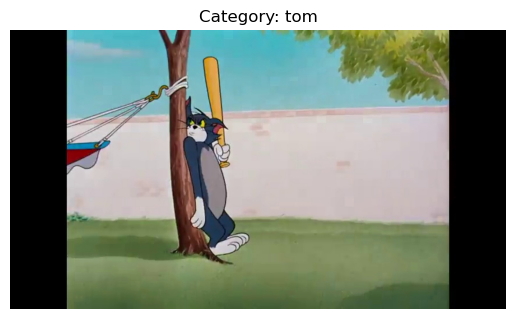

JERRY image shape: (854, 480) - frame3231.jpg


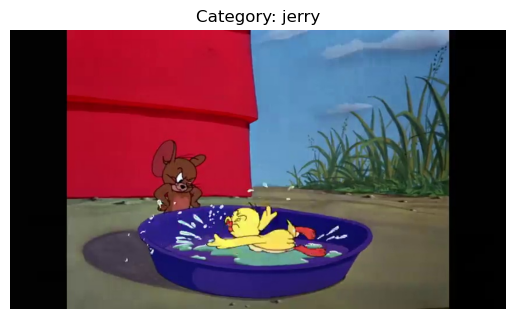

TOM_JERRY_1 image shape: (854, 480) - frame4326.jpg


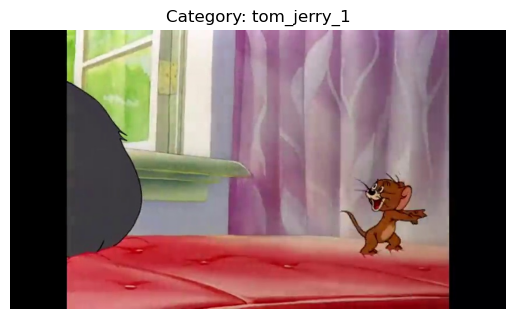

TOM_JERRY_0 image shape: (1280, 720) - frame1157.jpg


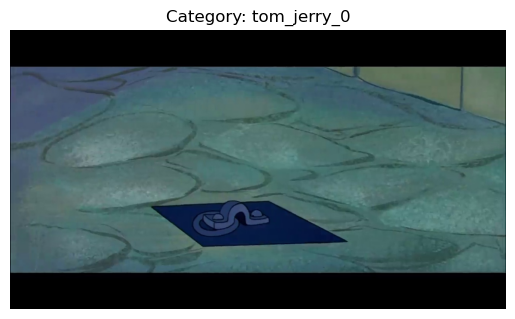

In [25]:
#now lets display the image shapes
for label, (img, path) in samples.items():
    #lin to return the image size
    print(f'{label.upper()} image shape: {img.size} - {os.path.basename(path)}')
    plt.imshow(img)
    plt.title(f'Category: {label}')
    plt.axis('off')
    plt.show()

## Data Preprocessing
### Resizing the images
Before we move to modelling, we need to preprocess and adjust our images. The most common steps are `resizing` and `flattening`.

**Resizing** maintains the sructure of the image but standardizes its size for efficient processing.

**Flattening** converts a multi-dimensional array/image into a vector(1D). This helps us in changing a 3D tensor into a 1D tensor for compatibility with dense layers in Neural networks.

In [30]:
#we'll use imagedatagenerator to resize 
size = (64, 64)
batch_size = 50 #the number of images to be processed at a time

#normalizing the data(think of this as similar step to using StandardScaler)
normalize = ImageDataGenerator(rescale=1./255, validation_split=0.3)

#create training set and validation set
train_set = normalize.flow_from_directory(
    base_dir, 
    target_size = size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='training',
    shuffle = True,
    color_mode =  'grayscale' #uncomment this line for faster runtime
)

#validation set 
validation_set = normalize.flow_from_directory(
    base_dir, 
    target_size = size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='validation',
    shuffle = True,
    color_mode =  'grayscale' #uncomment this line for faster runtime
)

Found 3835 images belonging to 4 classes.
Found 1643 images belonging to 4 classes.


- The `rescale=1.255` is to normalize the pixel values, which were initially RGB(0, 255) to (0, 1).

- `flow_from_directory` method from ImageDataGenerator has a special requirement that each of the different classes/labels we are modelling for be in its own subfolder.

Now we can move into building our Convolutional Neural Network and flatten the image before passing it into our dense layers.


In [32]:
##designing our CNN and dense layers
model = Sequential()

#CNN layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))  # grayscale images
model.add(MaxPool2D(pool_size=(2, 2)))


##CNN layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))


##flattening before pushing to dense layers
model.add(Flatten())

""" 
Design three hidden layers
First one with 128 neurons
Second one with 64 neurons
Third one with 32 neurons

Use Dropout technique on the first two with your desired percentage

Also include the output layer, choose the correct number of neurons and activation function

"""
# hidden layer 1
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate

# hidden layer 2
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Dropout layer with  30% dropout rate

# hidden layer 3
model.add(Dense(32, activation='relu'))

# output layer
model.add(Dense(4, activation='softmax'))  # 4 classes: tom, jerry, tom_jerry_1, tom_jerry_0

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), 
              loss='mse',  # Mean Squared Error for multi-class classification
              metrics=['accuracy'])

#write your code here

model.summary() #this line give you a table-like representation of your design

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,635,044 (6.24 MB)

 Trainable params: 1,635,044 (6.24 MB)

 Non-trainable params: 0 (0.00 B)

We'll now train our CNN using the training and validation datasets.


`PS:` The CNN model extracts different features from the images then our dense layer is used to interpret them and classify the image. 

In [33]:
"""
during training make sure to pick a small epoch to reduce run-time
replace ... with a valid number
"""
model.fit(
    train_set, 
    epochs=5,
    validation_data = validation_set
)

Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 52s 637ms/step - accuracy: 0.3472 - loss: 0.1987 - val_accuracy: 0.3713 - val_loss: 0.1817
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 48s 618ms/step - accuracy: 0.3936 - loss: 0.1766 - val_accuracy: 0.3731 - val_loss: 0.1814
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 52s 675ms/step - accuracy: 0.4218 - loss: 0.1718 - val_accuracy: 0.3585 - val_loss: 0.1826
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 48s 625ms/step - accuracy: 0.4208 - loss: 0.1696 - val_accuracy: 0.3488 - val_loss: 0.1900
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 47s 606ms/step - accuracy: 0.4538 - loss: 0.1607 - val_accuracy: 0.3640 - val_loss: 0.1858


### Evaluation 
Lets check how the model performs on the validation set.

Here are tables to help you:
| Validation Loss | Notes                            |
| --------------- | -------------------------------- |
| > 1.0           | Model struggling or too simple   |
| 0.8 – 1.0       | May still be improving           |
| 0.5 – 0.8       | Acceptable, improving            |
| 0.2 – 0.5       | Good model performance           |
| < 0.2           | Excellent, but check for overfit |

And an accuracy table

| Accuracy Range | Interpretation                                  |
| -------------- | ----------------------------------------------- |
| < 60%          | Likely underfitting or data issues              |
| 60–75%         | Learning, but room for model/data improvement   |
| 75–85%         | Good starting point, acceptable for class demos |
| 85–95%         | Strong, usable for screen time analysis         |
| > 95%          | Excellent, but check for overfitting            |


In [ ]:
# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(validation_set)
print(f"\nValidation Accuracy: {val_accuracy:.2f}")
print(f"Validation Loss: {val_loss:.4f}")


###  Prediction 
Now we need to create a helper function to utilize our model in prediction tasks.

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

"""
fill in the logic of the function:
1. load and preprocess the image
2. use the model to predict
3. Display the image and the prediction
"""
# Mapping from class index to label
class_labels = list(train_set.class_indices.keys())

def predict_and_render(image_path):

    #write your code here
    pass


In [ ]:
""" 
Testing your function on a random image
"""

#pick an image path manually
sample_image_path = os.path.join(base_dir, 'tom_jerry_1', random.choice(os.listdir(os.path.join(base_dir, 'tom_jerry_1'))))

#predict
predict_and_render(sample_image_path)
